In [22]:
import pandas as pd
import torchvision.models as models
from torch.nn import Parameter
import torch.nn.functional as F
import torch
import torch.nn as nn
import numpy as np
import math
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import json
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

In [23]:
# pickleFile = open("/content/workout_processed_data.json","rb")


# Opening JSON file
f = open('C:\\Users\\RedmiBook\\HUST\\Documents\\Studying\\Deep Learning\\project\\Human Pose Estimation\\code\\test\\Human-Pose-Correction\\dataset\\noised_workout.json')

# returns JSON object as
# a dictionary
data = json.load(f)
print(type(data))
for i in data:
    print(i)
    break

<class 'list'>
{'img_path': 'workout/data/barbell biceps curl/barbell biceps curl_3500031.jpg', 'pose_landmarks': [[0.4774287939071655, 0.24840272963047028], [0.5331271886825562, 0.4542478322982788], [0.45521247386932373, 0.45958471298217773], [0.4242556393146515, 0.7012475728988647], [0.3555398411694755, 0.5985070762659023], [0.6110419631004333, 0.4489109516143799], [0.6341942548751831, 0.7340845465660095], [0.5563402771949768, 0.6042554378509521], [0.46739861369132996, 0.8921239376068115], [0.49546916555797954, 1.1818725166345547], [0.4474429786205292, 1.457870364189148], [0.5698781609535217, 0.8972180485725403], [0.5868009924888611, 1.198378086090088], [0.5683548450469971, 1.4924317598342896], [0.47504422068595886, 0.21733975410461426], [0.47504422068595886, 0.21733975410461426], [0.48139142990112305, 0.22853988409042358], [0.5394233465194702, 0.236206516623497]], 'pose_world_landmarks': [[-0.06522616744041443, -0.6757313013076782, -0.2676267623901367, 0.998976469039917], [0.0597272

In [48]:
data[15]

{'img_path': 'workout/data/barbell biceps curl/barbell biceps curl_100051.jpg',
 'pose_landmarks': [[0.49560168385505676, 0.20373564958572388],
  [0.5372005105018616, 0.3497490882873535],
  [0.4718470275402069, 0.3526126742362976],
  [0.445637971162796, 0.5146890878677368],
  [0.4026880688611259, 0.6620741782213161],
  [0.6025540232658386, 0.34688547253608704],
  [0.6111825704574585, 0.5251014232635498],
  [0.5411056876182556, 0.6946909427642822],
  [0.4893687665462494, 0.6497761011123657],
  [0.5040549762192955, 0.8947796521211574],
  [0.47046127915382385, 1.095686912536621],
  [0.5547069907188416, 0.6609124541282654],
  [0.5373042225837708, 0.893583357334137],
  [0.5320765972137451, 1.1112579107284546],
  [0.4916688799858093, 0.17876705527305603],
  [0.4916688799858093, 0.17876705527305603],
  [0.4972502589225769, 0.18386241793632507],
  [0.5425045490264893, 0.18347835540771484]],
 'pose_world_landmarks': [[-0.08921493589878082,
   -0.666775643825531,
   -0.31181737780570984,
   0.99

In [24]:
"""https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py"""

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers


def pair(t):
    return t if isinstance(t, tuple) else (t, t)


# classes


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head**-0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = (
            nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout))
            if project_out
            else nn.Identity()
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        PreNorm(
                            dim,
                            Attention(
                                dim, heads=heads, dim_head=dim_head, dropout=dropout
                            ),
                        ),
                        PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)),
                    ]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class ViT(nn.Module):
    def __init__(
        self,
        *,
        image_size,
        patch_size,
        num_classes,
        dim,
        depth,
        heads,
        mlp_dim,
        pool="cls",
        channels=3,
        dim_head=64,
        dropout=0.0,
        emb_dropout=0.0
    ):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert (
            image_height % patch_height == 0 and image_width % patch_width == 0
        ), "Image dimensions must be divisible by the patch size."

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {
            "cls",
            "mean",
        }, "pool type must be either cls (cls token) or mean (mean pooling)"

        self.to_patch_embedding = nn.Sequential(
            Rearrange(
                "b c (h p1) (w p2) -> b (h w) (p1 p2 c)",
                p1=patch_height,
                p2=patch_width,
            ),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, num_classes))

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, "1 1 d -> b 1 d", b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, : (n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == "mean" else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [25]:

class ModulatedGraphConv(nn.Module):
    """
    Semantic graph convolution layer
    """

    def __init__(self, in_features, out_features, adj, bias=True):
        super(ModulatedGraphConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.W = nn.Parameter(torch.zeros(size=(2, in_features, out_features), dtype=torch.float))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        self.M = nn.Parameter(torch.ones(size=(adj.size(0), out_features), dtype=torch.float))

        self.adj = adj

        self.adj2 = nn.Parameter(torch.ones_like(adj))
        nn.init.constant_(self.adj2, 1e-6)

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features, dtype=torch.float))
            stdv = 1. / math.sqrt(self.W.size(2))
            self.bias.data.uniform_(-stdv, stdv)
        else:
            self.register_parameter('bias', None)

    def forward(self, input):
        h0 = torch.matmul(input, self.W[0])
        h1 = torch.matmul(input, self.W[1])

        adj = self.adj.to(input.device) + self.adj2.to(input.device)

        adj = (adj.T + adj)/2

        E = torch.eye(adj.size(0), dtype=torch.float).to(input.device)

        output = torch.matmul(adj * E, self.M*h0) + torch.matmul(adj * (1 - E), self.M*h1)
        if self.bias is not None:
            return output + self.bias.view(1, 1, -1)
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [26]:



class _NonLocalBlock(nn.Module):
    def __init__(self, in_channels, inter_channels=None, dimension=3, sub_sample=1, bn_layer=True):
        super(_NonLocalBlock, self).__init__()

        assert dimension in [1, 2, 3]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2

        assert self.inter_channels > 0

        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool = nn.MaxPool3d
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool = nn.MaxPool2d
            bn = nn.BatchNorm2d
        elif dimension == 1:
            conv_nd = nn.Conv1d
            max_pool = nn.MaxPool1d
            bn = nn.BatchNorm1d
        else:
            raise Exception('Error feature dimension.')

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)
        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)
        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        self.concat_project = nn.Sequential(
            nn.Conv2d(self.inter_channels * 2, 1, 1, 1, 0, bias=False),
            nn.ReLU()
        )

        nn.init.kaiming_normal_(self.concat_project[0].weight)
        nn.init.kaiming_normal_(self.g.weight)
        nn.init.constant_(self.g.bias, 0)
        nn.init.kaiming_normal_(self.theta.weight)
        nn.init.constant_(self.theta.bias, 0)
        nn.init.kaiming_normal_(self.phi.weight)
        nn.init.constant_(self.phi.bias, 0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(self.in_channels)
            )
            nn.init.kaiming_normal_(self.W[0].weight)
            nn.init.constant_(self.W[0].bias, 0)
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        if sub_sample > 1:
            self.g = nn.Sequential(self.g, max_pool(kernel_size=sub_sample))
            self.phi = nn.Sequential(self.phi, max_pool(kernel_size=sub_sample))

    def forward(self, x):
        batch_size = x.size(0)  # x: (b, c, t, h, w)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        # (b, c, N, 1)
        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1, 1)
        # (b, c, 1, N)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, 1, -1)

        h = theta_x.size(2)
        w = phi_x.size(3)
        theta_x = theta_x.expand(-1, -1, -1, w)
        phi_x = phi_x.expand(-1, -1, h, -1)

        concat_feature = torch.cat([theta_x, phi_x], dim=1)
        f = self.concat_project(concat_feature)
        b, _, h, w = f.size()
        f = f.view(b, h, w)

        N = f.size(-1)
        f_div_C = f / N

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        return z


class GraphNonLocal(_NonLocalBlock):
    def __init__(self, in_channels, inter_channels=None, sub_sample=1, bn_layer=True):
        super(GraphNonLocal, self).__init__(in_channels, inter_channels=inter_channels, dimension=1,
                                            sub_sample=sub_sample, bn_layer=bn_layer)

In [27]:
import functools


class _GraphConv(nn.Module):
    def __init__(self, adj, input_dim, output_dim, p_dropout=None):
        super(_GraphConv, self).__init__()

        self.gconv =  ModulatedGraphConv(input_dim, output_dim, adj)
        self.bn = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU()

        if p_dropout is not None:
            self.dropout = nn.Dropout(p_dropout)
        else:
            self.dropout = None

    def forward(self, x):
        x = self.gconv(x).transpose(1, 2)
        x = self.bn(x).transpose(1, 2)
        if self.dropout is not None:
            x = self.dropout(self.relu(x))

        x = self.relu(x)
        return x


class _ResGraphConv(nn.Module):
    def __init__(self, adj, input_dim, output_dim, hid_dim, p_dropout):
        super(_ResGraphConv, self).__init__()

        self.gconv1 = _GraphConv(adj, input_dim, hid_dim, p_dropout)
        self.gconv2 = _GraphConv(adj, hid_dim, output_dim, p_dropout)

    def forward(self, x):
        residual = x
        out = self.gconv1(x)
        out = self.gconv2(out)
        return residual + out


class _GraphNonLocal(nn.Module):
    def __init__(self, hid_dim, grouped_order, restored_order, group_size):
        super(_GraphNonLocal, self).__init__()

        self.non_local = GraphNonLocal(hid_dim, sub_sample=group_size)
        self.grouped_order = grouped_order
        self.restored_order = restored_order

    def forward(self, x):
        out = x[:, self.grouped_order, :]
        out = self.non_local(out.transpose(1, 2)).transpose(1, 2)
        out = out[:, self.restored_order, :]
        return out


class ModulatedGCN(nn.Module):
    def __init__(self, adj, hid_dim, coords_dim=(2, 3), num_layers=4, nodes_group=None, p_dropout=None, num_classes=82):
        super(ModulatedGCN, self).__init__()

        _gconv_input = [_GraphConv(adj, coords_dim[0], hid_dim, p_dropout=p_dropout)]
        _gconv_layers = []

        if nodes_group is None:
            for i in range(num_layers):
                _gconv_layers.append(_ResGraphConv(adj, hid_dim, hid_dim, hid_dim, p_dropout=p_dropout))
        else:
            group_size = len(nodes_group[0])
            assert group_size > 1

            grouped_order = list(functools.reduce(lambda x, y: x + y, nodes_group))
            restored_order = [0] * len(grouped_order)
            for i in range(len(restored_order)):
                for j in range(len(grouped_order)):
                    if grouped_order[j] == i:
                        restored_order[i] = j
                        break

            _gconv_input.append(_GraphNonLocal(hid_dim, grouped_order, restored_order, group_size))
            for i in range(num_layers):
                _gconv_layers.append(_ResGraphConv(adj, hid_dim, hid_dim, hid_dim, p_dropout=p_dropout))
                _gconv_layers.append(_GraphNonLocal(hid_dim, grouped_order, restored_order, group_size))
        self.reg_dim = coords_dim[1]*18
        self.gconv_input = nn.Sequential(*_gconv_input)
        self.gconv_layers = nn.Sequential(*_gconv_layers)
        self.gconv_output = ModulatedGraphConv(hid_dim, coords_dim[1], adj)
        self.linear1 = nn.Linear(self.reg_dim, 512)
        self.linear2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.gconv_input(x)
        out = self.gconv_layers(out)
        out = self.gconv_output(out)
        tokens = out.clone()
        out = out.view(-1, self.reg_dim)
        out = self.linear1(out)
        out = self.linear2(out)
        return out, tokens

In [28]:
class Corrector(nn.Module):
    def __init__(self, adj, num_tokens, dim_enc, depth, heads, dim_head, mlp_dim, num_labels, dropout=0.0, out_dim=2) -> None:
        super().__init__()
        self.adj = adj
        self.dim_enc = dim_enc
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        self.transfromer = Transformer(self.dim_enc, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout)
        self.label_emb = nn.Linear(num_labels, self.dim_enc)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_tokens + 1, dim_enc))
        self.mlp = ModulatedGraphConv(in_features=self.dim_enc, out_features=out_dim, adj=self.adj)

    def forward(self, label, skt):
        embed_lb = self.label_emb(label)
        print(embed_lb.shape, skt.shape)
        x = torch.concat((embed_lb, skt), dim=1)
        x += self.pos_embedding
        x = self.transfromer(x)
        out = self.mlp(x[:,1:,:])
        return out




In [29]:
class Predictor_Corrector(nn.Module):
    def __init__(self, adj, hid_dim, coords_dim=(2, 128), num_layers_pred=4, nodes_group=None, p_dropout=None, num_classes=82,
                 num_tokens=18, depth=4, heads=1, dim_head=64) -> None:
        super().__init__()
        self.adj = adj
        self.hid_dim = hid_dim
        self.coords_dim = coords_dim
        self.num_lalyers_pred = num_layers_pred
        self.nodes_group = nodes_group
        self.p_dropout = p_dropout
        self.num_classes = num_classes
        self.num_tokens = num_tokens
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head

        self.predictor = ModulatedGCN(adj=self.adj, hid_dim=self.hid_dim, coords_dim=self.coords_dim, num_layers=self.num_lalyers_pred, nodes_group=self.nodes_group, p_dropout=self.p_dropout, num_classes=self.num_classes).double()
        self.predictor.load_state_dict(torch.load('checkpoints\\workout\\best_predictor.pth',map_location=torch.device('cpu')))
        for param in self.predictor.parameters():
          param.requires_grad = False
        self.corrector = Corrector(adj = self.adj, num_tokens=self.num_tokens, dim_enc=self.coords_dim[1], depth=self.depth, heads=self.heads, dim_head=self.dim_head, mlp_dim=self.coords_dim[0], num_labels=self.num_classes)

    def forward(self, input):
        x, y = input
        out_pred, tokens = self.predictor(x.type(torch.float64))
        corrected_pose = self.corrector(y.type(torch.float64), tokens.type(torch.float64))
        out_corr,_ = self.predictor(corrected_pose.type(torch.float64))
        return out_corr, corrected_pose


In [30]:
edge = [ [1, 1, 2, 3, 5, 6, 1, 8, 9, 1, 11, 12, 1, 0, 14, 0, 15, 2, 5],
  [2, 5, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 0, 14, 16, 15, 17, 16, 17],
  ]
A = np.zeros((18,18))

In [31]:
for i,j in zip(edge[0], edge[1]):
    A[i,j] = 1
    A[j,i] = 1

In [32]:
import json
import random
from typing import List
import torch
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import Dataset
import numpy as np

class TrainDataset(Dataset):

    def __init__(self, json_path: str) -> None:
        super(TrainDataset, self).__init__()
        self.json_path = json_path
        self.img_list = self.get_img_list()
        # self.transforms = transforms
        self.label_to_index, self.num_classes = self.classes_to_idx()

    def get_img_list(self):
        with open(self.json_path, 'rb') as f:
            img_list = json.load(f)
        return img_list

    def classes_to_idx(self):
        label_to_index = {}
        index = 0
        for item in self.img_list:
            # print(item)
            label = item['label']
            if label not in label_to_index:
                label_to_index[label] = index
                index += 1
        return label_to_index, len(label_to_index)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        a_img = self.img_list[index]
        a_label = a_img['label']
        a_pose = a_img['pose_landmarks']

        a_pose_tensor = self.get_pose_tensor(a_pose)
        # p_pose_tensor = self.get_pose_tensor(p_pose)
        # n_pose_tensor = self.get_pose_tensor(n_pose)

        a_label_index = self.label_to_index[a_label]
        # return torch.concat((a_pose_tensor[:,:2], a_pose_tensor[:,-1].unsqueeze_(-1)), dim=1), a_label_index
        return a_pose_tensor[:,:2], a_label_index
    # def get_img_tensor(self, img_path):
    #     img = Image.open(img_path)
    #     img_tensor = self.transforms(img)
    #     return img_tensor

    def get_pose_tensor(self, pose: List[List[float]]):
        return torch.tensor(pose, dtype= float)
    def get_pose_index(self):
        return self.label_to_index

In [33]:


model = Predictor_Corrector(adj=torch.tensor(A), hid_dim=128, coords_dim=(2, 128), num_layers_pred=6, nodes_group=None, p_dropout=None, num_classes=22,
                            num_tokens=18, depth=2, heads=2, dim_head=64).double()

In [34]:
model.corrector.load_state_dict(torch.load('checkpoints\\workout\\best_corrector.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [35]:
noise_dataset = TrainDataset(json_path='dataset\\noised_workout.json')

In [36]:
def to_onehot(a, num_classes=22):
  print(a.shape[0])
  b = torch.zeros((a.shape[0], num_classes))
  b[torch.arange(a.shape[0]), a-1] = 1
  return b

In [37]:
noise_dataset[1]

(tensor([[0.4774, 0.2484],
         [0.5331, 0.4542],
         [0.4552, 0.4596],
         [0.4243, 0.7012],
         [0.3555, 0.5985],
         [0.6110, 0.4489],
         [0.6342, 0.7341],
         [0.5563, 0.6043],
         [0.4674, 0.8921],
         [0.4955, 1.1819],
         [0.4474, 1.4579],
         [0.5699, 0.8972],
         [0.5868, 1.1984],
         [0.5684, 1.4924],
         [0.4750, 0.2173],
         [0.4750, 0.2173],
         [0.4814, 0.2285],
         [0.5394, 0.2362]], dtype=torch.float64),
 0)

In [79]:
input = noise_dataset[15]
lb = to_onehot(np.array(([input[1]]))).unsqueeze(0).float()
xb = input[0]

1


In [80]:
logit = model.predictor(xb)[0]
torch.softmax(logit, dim=-1)[0][input[1]]

tensor(0.3031, dtype=torch.float64)

In [81]:
out_corr, corrected_pose = model([xb, lb])

torch.Size([1, 1, 128]) torch.Size([1, 18, 128])


In [82]:
logit1 = torch.softmax(out_corr, dim=-1)[0][input[1]]

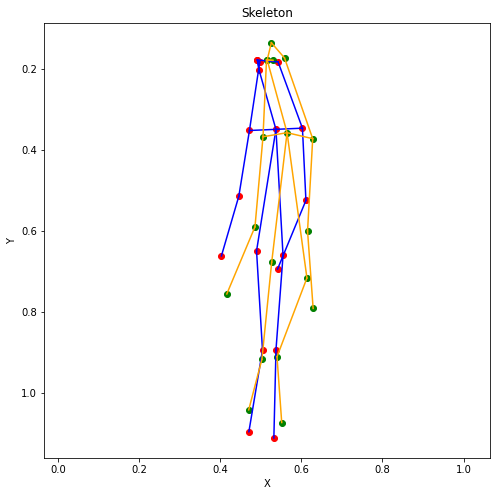

In [83]:

# Keypoints set 1
keypoints_1 = input[0] # Replace with the coordinates of keypoints set 1

# Keypoints set 2
keypoints_2 = corrected_pose.detach().numpy()[0]  # Replace with the coordinates of keypoints set 2

# Edge index
edge_index = np.array([
    [1, 1, 2, 3, 5, 6, 1, 8, 9, 1, 11, 12, 1, 0, 14, 0, 15, 2, 5],
    [2, 5, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 0, 14, 16, 15, 17, 16, 17],
])

# Plotting the skeleton
plt.figure(figsize=(8, 8))
# img = mpimg.imread(data['img_path'])
# plt.imshow(img)
# Plot keypoints set 1
plt.scatter(keypoints_1[:, 0], keypoints_1[:, 1], color='red')
for i in range(edge_index.shape[1]):
    x = [keypoints_1[edge_index[0, i], 0], keypoints_1[edge_index[1, i], 0]]
    y = [keypoints_1[edge_index[0, i], 1], keypoints_1[edge_index[1, i], 1]]
    plt.plot(x, y, color='blue')

# Plot keypoints set 2
plt.scatter(keypoints_2[:, 0], keypoints_2[:, 1], color='green')
for i in range(edge_index.shape[1]):
    x = [keypoints_2[edge_index[0, i], 0], keypoints_2[edge_index[1, i], 0]]
    y = [keypoints_2[edge_index[0, i], 1], keypoints_2[edge_index[1, i], 1]]
    plt.plot(x, y, color='orange')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Skeleton')
plt.axis('equal')
# plt.legend()
plt.gca().invert_yaxis() 
plt.show()
